<a href="https://colab.research.google.com/github/TobyHerlong/Finance/blob/main/Option_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements a **Gamma Scalping strategy** with a **Bollinger Band filter** and compares its performance against a simple **Buy & Hold strategy**.

**Key Aspects:**
-   **Strategy Logic**: The strategy sells (writes) short-term call options on a monthly schedule. A key filter for initiating a new call option position is the **Bollinger Band Width**. If the Bollinger Band width is above a certain threshold (indicating higher volatility or price dispersion), the strategy enters a new call option position.
-   **Option Pricing**: Uses the Black-Scholes model (`bs_call_price`) to calculate option premiums and mark-to-market (MTM) the existing call options.
-   **Risk-Free Rate**: A `RISK_FREE` rate is used in the Black-Scholes model and for Sharpe Ratio calculation.
-   **Volatility Measurement**: Realized volatility (`realized_vol`) over a lookback period is used as an input for the Black-Scholes model.
-   **Performance Metrics**: The strategy's performance is evaluated based on its **Annualized Return**, **Annualized Volatility**, and **Sharpe Ratio**, and these are compared directly against the Buy & Hold strategy for the same period.
-   **Backtesting**: The code backtests the strategy over the specified number of `YEARS` (5 years in this case) for the given `TICKER` (HCKT).

Download 5 years of data on HCKT

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameters
TICKER = "HCKT"
YEARS = 5
RISK_FREE = 0.02
VOL_LOOKBACK = 60
BB_PERIOD = 20
BB_WIDTH_THRESHOLD = 0.10
MIN_SIGMA = 1e-6

# Black-Scholes pricing
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Realized volatility
def realized_vol(ret, window=60, td=252):
    return ret.rolling(window).std() * np.sqrt(td)

# Bollinger Band width
def bollinger_band_width(price, period=20):
    sma = price.rolling(period).mean()
    std = price.rolling(period).std()
    upper = sma + 2 * std
    lower = sma - 2 * std
    return (upper - lower) / sma

# Third Fridays
def third_fridays(start, end):
    return pd.date_range(start=start, end=end, freq='WOM-3FRI')

# Align to trading days
def align_to_trading_day(dates, trading_index):
    aligned = []
    for d in dates:
        d = pd.Timestamp(d)
        if d in trading_index:
            aligned.append(d)
        else:
            loc = trading_index.searchsorted(d)
            if loc == 0:
                continue
            aligned.append(trading_index[loc - 1])
    return pd.DatetimeIndex(aligned)

Plot the data and show buy and hold pattern

[*********************100%***********************]  1 of 1 completed


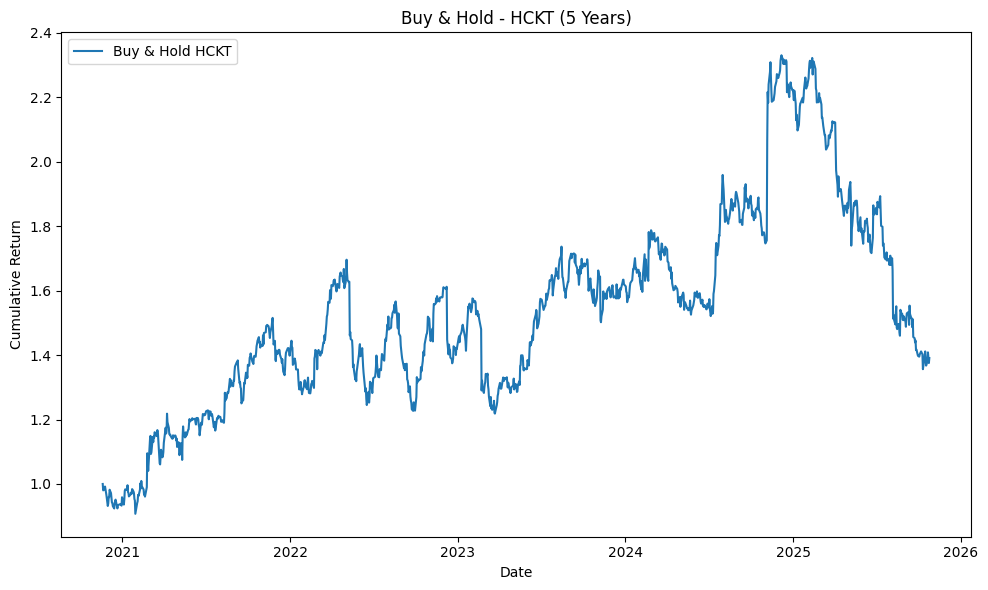

In [ ]:
# Download data
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=YEARS)
raw = yf.download(TICKER, start=start - pd.DateOffset(months=2), end=end, auto_adjust=True)
close = raw["Close"].dropna()
df = pd.DataFrame(index=close.index)
df["Close"] = close
df["Ret"] = df["Close"].pct_change()
df["Sigma"] = realized_vol(df["Ret"], VOL_LOOKBACK)
df["BBWidth"] = bollinger_band_width(df["Close"], BB_PERIOD)
df = df.dropna().copy()

# Plot Buy and Hold
plt.figure(figsize=(10,6))
plt.plot(df.index, df["Close"] / df["Close"].iloc[0], label=f"Buy & Hold {TICKER}")
plt.title(f"Buy & Hold - {TICKER} ({YEARS} Years)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

Create an option trading strategy using Gamma Scalping with Bollinger Band Filter


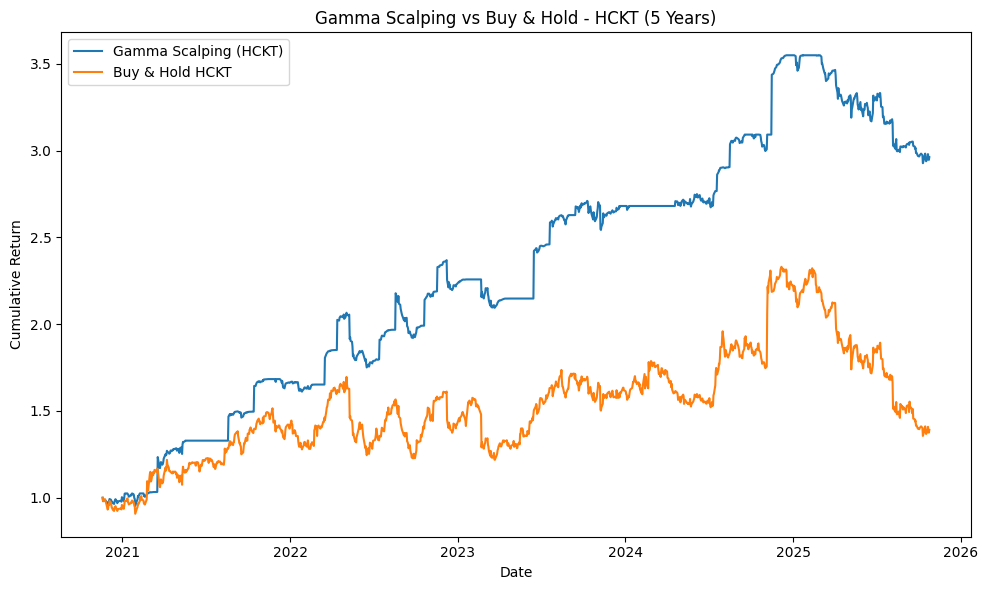

==== Gamma Scalping Summary ====
Annualized Return : 27.13%
Annualized Volatility : 19.88%
Sharpe Ratio (rf=2%) : 1.26

==== Buy & Hold Summary ====
Annualized Return : 11.50%
Annualized Volatility : 28.92%
Sharpe Ratio (rf=2%) : 0.33


In [ ]:
# Monthly schedule
third_fris = third_fridays(df.index[0], df.index[-1])
roll_dates = align_to_trading_day(third_fris, df.index)
df["Roll"] = df.index.isin(roll_dates)
df["CallVal"] = 0.0
df["Cash"] = 0.0
df["Value"] = np.nan

# Backtest
active_strike = np.nan
active_expiry_idx = None
dates = df.index

for i, dt in enumerate(dates):
    S_t = df.at[dt, "Close"]
    sigma = max(df.at[dt, "Sigma"], MIN_SIGMA)
    bb_width = df.at[dt, "BBWidth"]

    # MTM call
    if not np.isnan(active_strike):
        T_rem = max((active_expiry_idx - i) / 252.0, 0.0)
        df.at[dt, "CallVal"] = bs_call_price(S_t, active_strike, T_rem, RISK_FREE, sigma)

    # Roll
    if df.at[dt, "Roll"] and bb_width > BB_WIDTH_THRESHOLD:
        T = 21 / 252.0
        K = float(np.round(S_t, 2))
        premium = bs_call_price(S_t, K, T, RISK_FREE, sigma)
        df.at[dt, "Cash"] += premium
        active_strike = K
        active_expiry_idx = min(i + 21, len(dates) - 1)
        df.at[dt, "CallVal"] = bs_call_price(S_t, K, T, RISK_FREE, sigma)

    # Carry forward cash
    if i > 0:
        df.at[dt, "Cash"] += df.iloc[i-1]["Cash"]

    # Portfolio value
    df.at[dt, "Value"] = S_t + df.at[dt, "Cash"] - df.at[dt, "CallVal"]

# Performance
strategy = df["Value"].dropna()
bh = df["Close"].loc[strategy.index]

# Calculate performance for Buy and Hold
bh_daily = bh.pct_change().dropna()
bh_ann_ret = (1 + bh_daily.mean()) ** 252 - 1
bh_ann_vol = bh_daily.std() * np.sqrt(252)
bh_sharpe = (bh_ann_ret - RISK_FREE) / bh_ann_vol


cum_strategy = strategy / strategy.iloc[0]
cum_bh = bh / bh.iloc[0]
daily = strategy.pct_change().dropna()
ann_ret = (1 + daily.mean()) ** 252 - 1
ann_vol = daily.std() * np.sqrt(252)
sharpe = (ann_ret - RISK_FREE) / ann_vol

# Plot
plt.figure(figsize=(10,6))
plt.plot(cum_strategy.index, cum_strategy, label="Gamma Scalping (HCKT)")
plt.plot(cum_bh.index, cum_bh, label="Buy & Hold HCKT")
plt.title("Gamma Scalping vs Buy & Hold - HCKT (5 Years)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print("==== Gamma Scalping Summary ====")
print(f"Annualized Return : {ann_ret:.2%}")
print(f"Annualized Volatility : {ann_vol:.2%}")
print(f"Sharpe Ratio (rf=2%) : {sharpe:.2f}")
print("\n==== Buy & Hold Summary ====")
print(f"Annualized Return : {bh_ann_ret:.2%}")
print(f"Annualized Volatility : {bh_ann_vol:.2%}")
print(f"Sharpe Ratio (rf=2%) : {bh_sharpe:.2f}")